# Discover Ri

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")

In [2]:
import deepmatcher as dm
import pandas as pd
import torch

In [9]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.explainer import Explainer

In [4]:
walmartamazon_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
walmartamazon_hybrid.load_state('../../models/walmartamazon_hybrid.pth')
walmartamazon_hybrid = walmartamazon_hybrid.to('cuda')

In [16]:
DATA_DIR = '../../datasets/Structured/Walmart-Amazon/'

In [5]:
negatives  = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
    '../../datasets/Structured/Walmart-Amazon','negatives',0)

In [6]:
positives  = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
    '../../datasets/Structured/Walmart-Amazon','positives',1)

## Ri discovery

### Negative samples analysis

In [8]:
attributes =['title','category','brand','modelno','price']
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

In [10]:
explainer = Explainer(walmartamazon_hybrid,attributes)

In [12]:
testneg_ri,testneg_ri_agg,testneg = explainer.getRankingsWhiteBox('../../datasets/Structured/Walmart-Amazon/',
                                                                  'test_negatives',0,'cosine')

Computing vectors in the classifier space


100%|██████████| 1787/1787 [05:31<00:00,  5.38it/s]


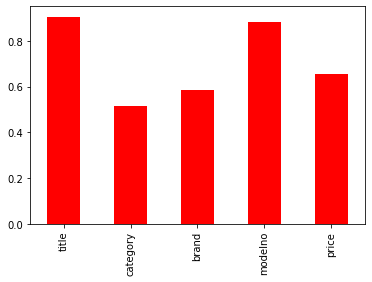

In [14]:
testneg_plt = testneg_ri_agg.drop(['sample_id'],axis=1).mean(numeric_only=True).plot.bar(color='red')

In [24]:
testneg_plt_fig = testneg_plt.get_figure()
testneg_plt_fig.savefig('testneg_ri.png',dpi=300,bbox_inches='tight')

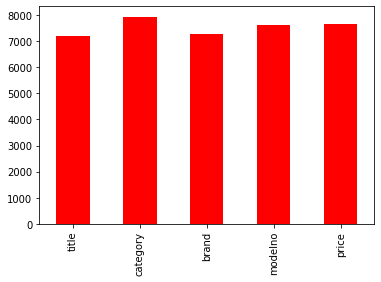

In [15]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum(numeric_only=True).plot.bar(color='red')

In [33]:
torch.save(neg_ri,'experiment_results/testneg_ri_hybrid.pt')
neg_ri_norms.to_csv('experiment_results/testneg_ri_norms_hybrid.csv',index=False)

### Positive samples analysis

In [18]:
testpos_ri,testpos_ri_agg,testpos_ri = explainer.getRankingsWhiteBox(DATA_DIR,'test_positives',1,'cosine')
torch.save(testpos_ri,'experiment_results/testpos_ri_hybrid.pt')
testpos_ri_agg.to_csv('experiment_results/testpos_ri_cosine_hybrid.csv',index=False)

Computing vectors in the classifier space


100%|██████████| 120/120 [00:32<00:00,  3.73it/s]


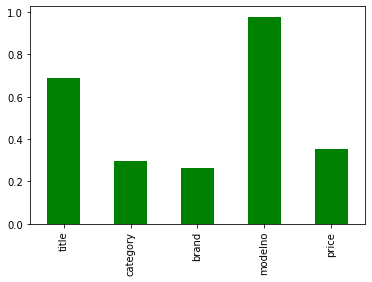

In [21]:
testpos_plt = testpos_ri_agg.drop(['sample_id'],axis=1).mean(numeric_only=True).plot.bar(color='green')

In [23]:
testpos_plt_fig = testpos_plt.get_figure()
testpos_plt_fig.savefig('testpos_ri.png',dpi=300,bbox_inches='tight')

## Nearest neighbors

In [37]:
from utils.distance_measures import nearestNeighborOnAttributes

In [38]:
testpos_nn = nearestNeighborOnAttributes(testpos,pos_ri,negatives,attributes,attribute_len
                                                       ,min_similarity=-1)

100%|██████████| 120/120 [00:01<00:00, 119.09it/s]


In [39]:
testneg_nn = nearestNeighborOnAttributes(testneg,neg_ri,positives,attributes,attribute_len,
                                         min_similarity=-1)

100%|██████████| 1787/1787 [00:04<00:00, 439.55it/s]


In [40]:
testpos_nn.to_csv('experiment_results/testpos_nn_hybrid.csv',index=False)
testneg_nn.to_csv('experiment_results/testneg_nn_hybrid.csv',index=False)

## Closest distances of nearest neighbors

In [7]:
from utils.distance_measures import smallestDistanceOnAttributes,correctRankings

In [8]:
testpos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')
testneg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')

In [14]:
testpos_nn_distances = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 120/120 [00:00<00:00, 137.73it/s]


In [15]:
testneg_nn_distances = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 1787/1787 [00:02<00:00, 685.53it/s]


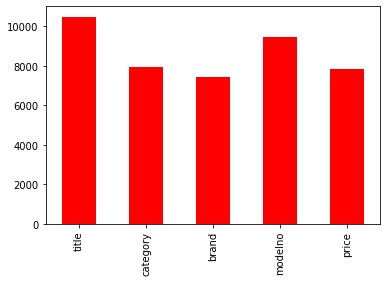

In [26]:
testneg_nn_distances.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

In [47]:
testneg_ri_norms = pd.read_csv('experiment_results/testneg_ri_norms_hybrid.csv')
testpos_ri_norms = pd.read_csv('experiment_results/testpos_ri_norms_hybrid.csv')

In [48]:
correct_rankings_testneg = correctRankings(testneg_ri_norms,testneg_nn_distances)
correct_rankings_testpos = correctRankings(testpos_ri_norms,testpos_nn_distances)

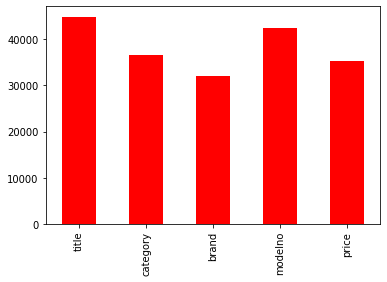

In [49]:
correct_rankings_testneg.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

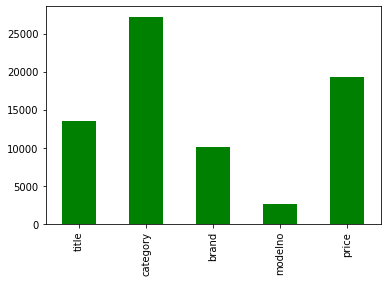

In [50]:
correct_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

In [53]:
testneg_nn_distances.mean()

title           0.836022
category        0.520233
brand           0.569137
modelno         0.851537
price           0.658255
sample_id    9171.526581
dtype: float64

## Closest distances with extended data

In [21]:
extended_neg = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
                                 '../../datasets/Structured/Walmart-Amazon','extended_negatives',0)

In [22]:
extended_pos = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
                                 '../../datasets/Structured/Walmart-Amazon','extended_positives',1)

In [23]:
testpos_nn_distances_extended = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       extended_neg,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 120/120 [00:00<00:00, 121.32it/s]


In [24]:
testneg_nn_distances_extended = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        extended_pos,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 1787/1787 [00:04<00:00, 386.79it/s]


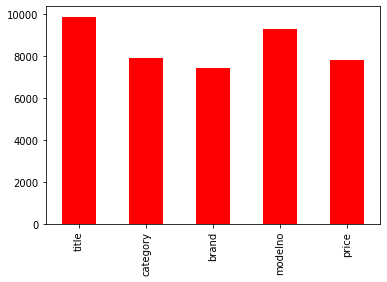

In [25]:
testneg_nn_distances_extended.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

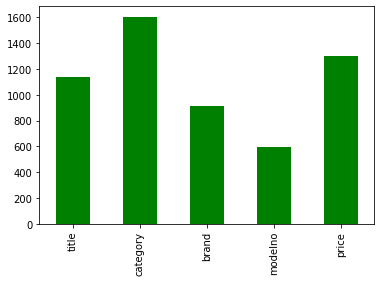

In [28]:
testpos_nn_distances_extended.drop(['sample_id'],axis=1).sum().plot.bar(color='green')